## Bring in the data and preview it

In [2]:
import os
import random
import numpy as np
import torch

def set_seed(seed= 24):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(24)

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

username = 'Andrew_Reusche92'
api_key = '63cd28af853827307d2b6546dd833488'

api_token = {"username":username,"key":api_key}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ronakgohil/license-plate-dataset

Dataset URL: https://www.kaggle.com/datasets/ronakgohil/license-plate-dataset
License(s): CC0-1.0


In [5]:
!unzip -q license-plate-dataset.zip -d data

In [6]:
#general purpose libraries
import os
import shutil
import math
import itertools
from glob import glob

#data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

#pytorch core libraries
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#pytorch utilities
from torch.utils.data import Dataset, DataLoader

#TorchVision libraries
import torchvision
from torchvision import transforms
from torchvision.ops import generalized_box_iou

#Scikit-learn utilities
from sklearn.model_selection import train_test_split

In [7]:
#data paths
image_dir = 'data/archive/images/train'
label_dir = 'data/archive/labels/train'

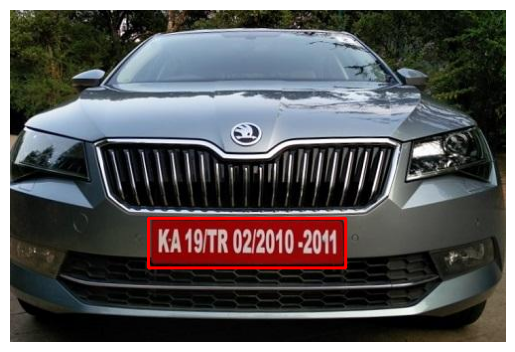

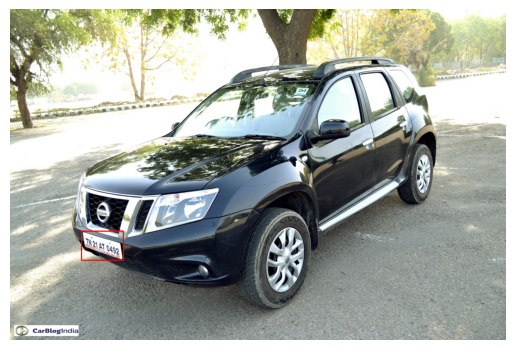

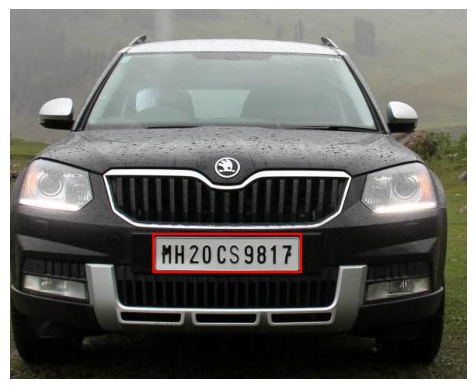

In [8]:
#deal with label paths that end in '.txt.txt'
def clean_label_path(label_path):
    if label_path.endswith('.txt.txt'):
        return label_path.replace('.txt.txt', '.txt')
    return label_path

#show images with boxes
def show_images_with_boxes(image_path, label_path, return_img= False):
  label_path= clean_label_path(label_path)
  img= cv2.imread(image_path)
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w, _= img.shape

  with open(label_path, 'r') as f:
    boxes= f.readlines()

  for box in boxes:
    class_id, x_center, y_center, box_w, box_h= map(float, box.strip().split())
    x1= int((x_center - box_w / 2) *w)
    y1= int((y_center - box_h / 2) *h)
    x2= int((x_center + box_w / 2) *w)
    y2= int((y_center + box_h / 2) *h)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

  if return_img:
    return img
  else:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#show some examples
sample_imgs= sorted(os.listdir(image_dir))[:3]

for img_file in sample_imgs:
  label_file= os.path.splitext(img_file)[0] + '.txt'
  label_path= os.path.join(label_dir, label_file)
  image_path= os.path.join(image_dir, img_file)

  show_images_with_boxes(image_path, label_path)

## Data Exploration

In [9]:
#count the images in each directory
train_imgs= glob('data/archive/images/train/*.jpg')
train_labels= glob('data/archive/labels/train/*.txt')
val_imgs= glob('data/archive/images/val/*.jpg')
val_labels= glob('data/archive/labels/val/*.txt')

print('Train images:', len(train_imgs))
print('Train labels:', len(train_labels))
print('Validation images:', len(val_imgs))
print('Validation labels:', len(val_labels))

Train images: 1526
Train labels: 1526
Validation images: 169
Validation labels: 169


In [10]:
#make sure every image has a matching label file
def check_missing_labels(img_paths, label_dir):
    missing= []
    for img_path in img_paths:
        base= os.path.splitext(os.path.basename(img_path))[0]
        label_path= os.path.join(label_dir, base + ".txt")
        if not os.path.exists(label_path):
            missing.append(img_path)
    return missing

missing_train= check_missing_labels(train_imgs, 'data/archive/labels/train')
missing_val= check_missing_labels(val_imgs, 'data/archive/labels/val')

print(f"Missing labels in training set: {len(missing_train)}")
print(f"Missing labels in validation set: {len(missing_val)}")

Missing labels in training set: 0
Missing labels in validation set: 0


In [11]:
#check out the class distribution to confirm they are all "license plate"
with open("data/archive/classes.txt", "r") as f:
    classes= f.read().splitlines()

print(f"Classes ({len(classes)}): {classes}")

Classes (1): ['license_plate']


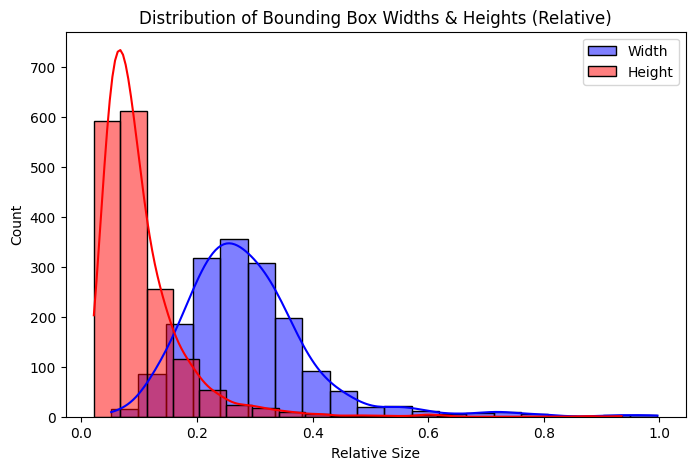

,width,height
count,1695.000000,1695.000000
mean,0.288975,0.103054
std,0.117831,0.076331
min,0.051471,0.021452
25%,0.216295,0.057851
50%,0.272059,0.082589
75%,0.337444,0.123077
max,0.996667,0.934483


In [12]:
#check out bounding box size distribution
def get_bbox_dims(label_files):
    widths= []
    heights= []
    for lbl in label_files:
        with open(lbl, 'r') as f:
            for line in f.readlines():
                parts= line.strip().split()
                if len(parts) == 5:
                    _, _, _, w, h= map(float, parts)
                    widths.append(w)
                    heights.append(h)
    return pd.DataFrame({'width': widths, 'height': heights})

bbox_df= get_bbox_dims(train_labels + val_labels)

#plot the bounding box distribution
plt.figure(figsize=(8, 5))
sns.histplot(bbox_df['width'], bins=20, kde=True, color='blue', label='Width')
sns.histplot(bbox_df['height'], bins=20, kde=True, color='red', label='Height')
plt.title("Distribution of Bounding Box Widths & Heights (Relative)")
plt.xlabel("Relative Size")
plt.legend()
plt.show()

bbox_df.describe()

100%|██████████| 1695/1695 [00:00<00:00, 7281.55it/s]


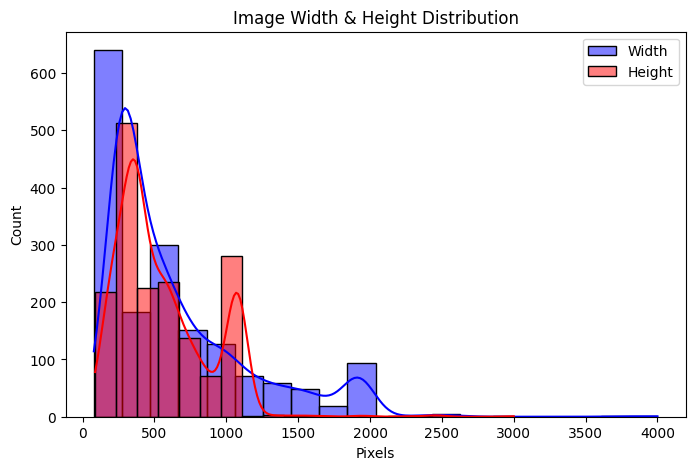

,width,height
count,1695.000000,1695.000000
mean,654.546313,554.525664
std,499.585320,321.803263
min,78.000000,87.000000
25%,272.000000,333.000000
50%,485.000000,451.000000
75%,859.500000,734.000000
max,4000.000000,3000.000000


In [15]:
#inspect distribution of image sizes
def get_image_sizes(image_paths):
    widths= []
    heights= []
    for path in tqdm(image_paths):
      with Image.open(path) as img:
        w, h= img.size
        widths.append(w)
        heights.append(h)

    return pd.DataFrame({'width': widths, 'height': heights})

all_imgs= train_imgs + val_imgs
img_dims_df= get_image_sizes(all_imgs)

#print(img_dims_df.describe())

plt.figure(figsize=(8, 5))
sns.histplot(img_dims_df['width'], bins=20, kde=True, color='blue', label='Width')
sns.histplot(img_dims_df['height'], bins=20, kde=True, color='red', label='Height')
plt.title("Image Width & Height Distribution")
plt.xlabel("Pixels")
plt.legend()
plt.show()

img_dims_df.describe()

## Data Preprocessing

Letterbox Resizing (padded resize)

In [16]:
#define input and output file paths
input_img_dir= "data/archive/images/train"
input_lbl_dir= "data/archive/labels/train"

output_img_dir= "data/processed/images"
output_lbl_dir= "data/processed/labels"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_lbl_dir, exist_ok=True)

In [17]:
#define target dimensions
target_w= 512
target_h= 512

In [18]:
#function to resize the images
def letterbox_resize(image, target_width, target_height):
    h, w= image.shape[:2]
    scale= min(target_width / w, target_height / h)
    new_w= int(w * scale)
    new_h= int(h * scale)

    resized= cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    pad_w= target_width - new_w
    pad_h= target_height - new_h
    top= pad_h // 2
    bottom= pad_h - top
    left= pad_w // 2
    right= pad_w - left

    padded= cv2.copyMakeBorder(resized,
                                top,
                                bottom,
                                left,
                                right,
                                cv2.BORDER_CONSTANT,
                                value=(114, 114, 114))

    return padded, scale, left, top, w, h

#function to resize the labels
def process_labels(label_path, scale, pad_left, pad_top, orig_w, orig_h):
    new_lines= []

    with open(label_path, 'r') as f:
        lines= f.readlines()

    for line in lines:
        class_id, x, y, w, h= map(float, line.strip().split())

        #undo YOLO normalization
        x *= orig_w
        y *= orig_h
        w *= orig_w
        h *= orig_h

        #scale
        x *= scale
        y *= scale
        w *= scale
        h *= scale

        #add padding offset
        x += pad_left
        y += pad_top

        #re-normalize
        x /= target_w
        y /= target_h
        w /= target_w
        h /= target_h

        new_lines.append(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    return new_lines

#function to preprocess data subset
def preprocess_yolo_dataset(input_img_dir,
                            input_lbl_dir,
                            output_img_dir,
                            output_lbl_dir,
                            target_w=512,
                            target_h=512):

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    image_files= [f for f in os.listdir(input_img_dir)
                 if f.lower().endswith('.jpg')]

    for img_file in tqdm(image_files, desc=f"Preprocessing {os.path.basename(input_img_dir)}"):
        img_path= os.path.join(input_img_dir, img_file)
        label_filename= os.path.splitext(img_file)[0] + '.txt'
        label_path= os.path.join(input_lbl_dir, label_filename)

        image= cv2.imread(img_path)

        pad_img, scale, pad_left, pad_top, orig_w, orig_h= letterbox_resize(image,
                                                                            target_w,
                                                                            target_h)

        #save the padded image
        out_img_path= os.path.join(output_img_dir, img_file)
        cv2.imwrite(out_img_path, pad_img)

        #process and save image
        if os.path.exists(label_path):
            new_label_lines = process_labels(label_path,
                                             scale,
                                             pad_left,
                                             pad_top,
                                             orig_w,
                                             orig_h)

            out_lbl_path= os.path.join(output_lbl_dir,
                                        label_filename)

            with open(out_lbl_path, 'w') as f:
                f.write('\n'.join(new_label_lines))

In [19]:
#preprocess the train subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/train',
    input_lbl_dir= 'data/archive/labels/train',
    output_img_dir= 'data/processed/images',
    output_lbl_dir= 'data/processed/labels')

#preprocess the validation subset
preprocess_yolo_dataset(input_img_dir= 'data/archive/images/val',
    input_lbl_dir= 'data/archive/labels/val',
    output_img_dir= 'data/processed_val/images',
    output_lbl_dir= 'data/processed_val/labels')

Preprocessing val: 100%|██████████| 169/169 [00:01<00:00, 103.95it/s]


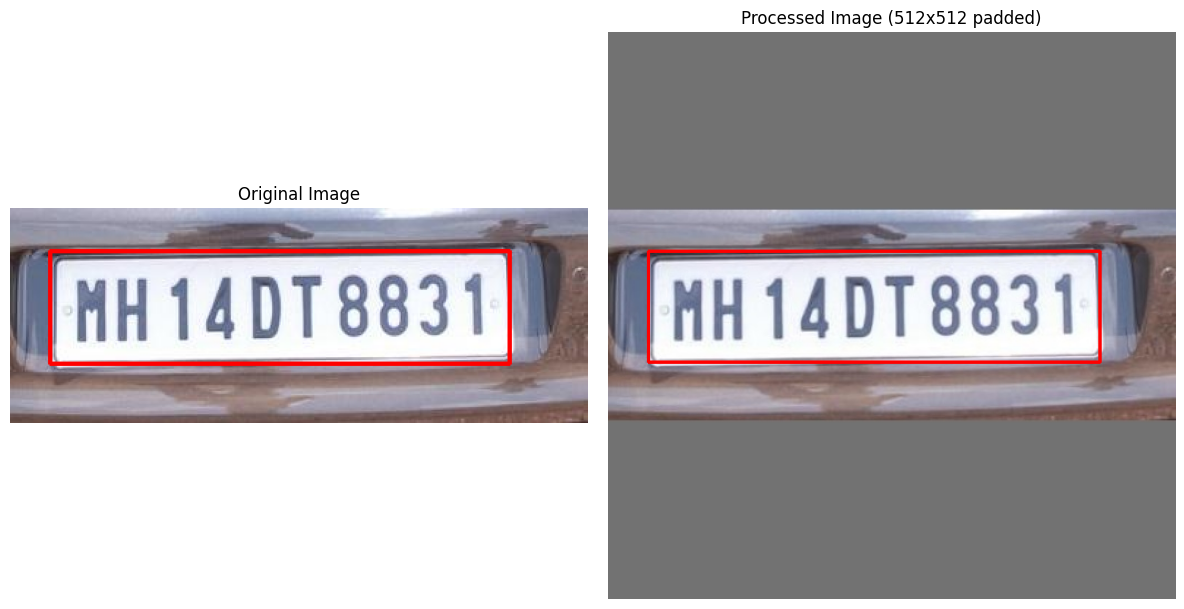

In [20]:
#create function to show image and bounding box before and after transformation
def show_images_side_by_side(img1_path, lbl1_path, img2_path, lbl2_path):
    img1= show_images_with_boxes(img1_path, lbl1_path, return_img=True)
    img2= show_images_with_boxes(img2_path, lbl2_path, return_img=True)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Processed Image (512x512 padded)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

#show before and after example from subset of uncomplicated file names
image_files= [f for f in os.listdir(input_img_dir) if f.lower().endswith('.jpg')]
trans_example= sorted(image_files)[8]
#fix label name edge cases
label_filename= os.path.splitext(trans_example)[0] + '.txt'


show_images_side_by_side(os.path.join(input_img_dir, trans_example),
                         os.path.join(input_lbl_dir, label_filename),
                         os.path.join(output_img_dir, trans_example),
                         os.path.join(output_lbl_dir, label_filename))

## Model Building and Data Analysis

### Train-Validation-Test Split

In [21]:
#preprocessed data paths
processed_train_img_dir= 'data/processed/images'
processed_train_lbl_dir= 'data/processed/labels'
processed_val_img_dir= 'data/processed_val/images'
processed_val_lbl_dir= 'data/processed_val/labels'

#output split base directory
split_base= 'data/final_split'
os.makedirs(split_base, exist_ok= True)

#get all preprocessed image-label pairs
train_images= sorted([f for f in os.listdir(processed_train_img_dir)
              if f.endswith('.jpg')])
train_pairs= [(f, os.path.splitext(f)[0] + '.txt') for f in train_images]

#train test split
train_split, test_split= train_test_split(train_pairs,
                                           test_size=0.1,
                                           random_state=24)
#copy image-label pairs to split directories
def copy_split(pairs, dest_split, src_img_dir, src_lbl_dir):
    img_out= os.path.join(split_base, dest_split, 'images')
    lbl_out= os.path.join(split_base, dest_split, 'labels')
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    for img_file, lbl_file in tqdm(pairs, desc=f"Copying {dest_split}"):
        shutil.copy(os.path.join(src_img_dir, img_file),
                    os.path.join(img_out, img_file))
        shutil.copy(os.path.join(src_lbl_dir, lbl_file),
                    os.path.join(lbl_out, lbl_file))

#copy final splits
copy_split(train_split, 'train', processed_train_img_dir, processed_train_lbl_dir)
copy_split(test_split, 'test', processed_train_img_dir, processed_train_lbl_dir)

#copy preprocessed validation set as-is
val_pairs= [(f, os.path.splitext(f)[0] + '.txt')
            for f in os.listdir(processed_val_img_dir) if f.endswith('.jpg')]

copy_split(val_pairs, 'val', processed_val_img_dir, processed_val_lbl_dir)

#print the sizes from each split
print("\nTrain size:", len(os.listdir('data/final_split/train/images')))
print("Val size:  ", len(os.listdir('data/final_split/val/images')))
print("Test size: ", len(os.listdir('data/final_split/test/images')))

Copying val: 100%|██████████| 169/169 [00:00<00:00, 684.83it/s]


Train size: 1373
Val size:   169
Test size:  153


### Create Pytorch Dataset and Dataloader with Transformations

In [22]:
class LicensePlateDataset(Dataset):
  def __init__(self, image_dir, label_dir, transform= None):
    self.image_dir= image_dir
    self.label_dir= label_dir
    self.image_files= sorted([f for f in os.listdir(image_dir)
                              if f.endswith('.jpg')])
    self.transform= transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_file= self.image_files[idx]
    label_file= os.path.splitext(img_file)[0] + '.txt'

    image_path= os.path.join(self.image_dir, img_file)
    label_path= os.path.join(self.label_dir, label_file)

    image= Image.open(image_path).convert('RGB')

    with open(label_path, 'r') as f:
      line= f.readline().strip()
      parts= line.split()
      bbox= torch.tensor(list(map(float, parts[1:])), dtype= torch.float32)

    if self.transform:
      image= self.transform(image)

    return image, bbox

In [23]:
transform= transforms.Compose([transforms.ToTensor(), ])

#path
base_path= 'data/final_split'

train_dataset= LicensePlateDataset(os.path.join(base_path, 'train/images'),
                                    os.path.join(base_path, 'train/labels'),
                                    transform=transform)

val_dataset= LicensePlateDataset(os.path.join(base_path, 'val/images'),
                                  os.path.join(base_path, 'val/labels'),
                                  transform=transform)

test_dataset= LicensePlateDataset(os.path.join(base_path, 'test/images'),
                                   os.path.join(base_path, 'test/labels'),
                                   transform=transform)

#data loaders
train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

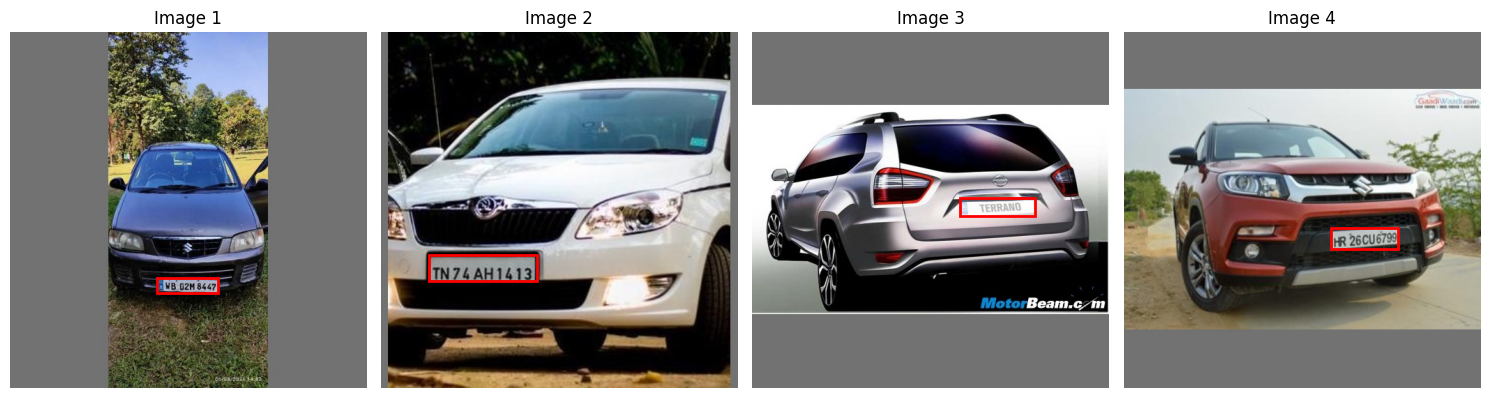

In [24]:
#preview transformed sample with bounding boxes
def show_batch_with_boxes(dataloader, batch_size= 4):
    images, bboxes= next(iter(dataloader))
    images= images[:batch_size]
    bboxes= bboxes[:batch_size]

    fig, axs= plt.subplots(1, batch_size, figsize= (15, 5))

    for i in range(batch_size):
        img= images[i].permute(1, 2, 0).numpy()
        h, w, _= img.shape

        x_center, y_center, box_w, box_h= bboxes[i].tolist()
        x1= int((x_center - box_w / 2) * w)
        y1= int((y_center - box_h / 2) * h)
        x2= int((x_center + box_w / 2) * w)
        y2= int((y_center + box_h / 2) * h)

        axs[i].imshow(img)
        axs[i].add_patch(plt.Rectangle((x1, y1),
                                       x2 - x1,
                                       y2 - y1,
                                       edgecolor='red',
                                       facecolor='none',
                                       linewidth=2))
        axs[i].axis('off')
        axs[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

show_batch_with_boxes(train_loader, batch_size= 4)